# Evaluate best model on testing dataset

During model training, the per-epoch performance is validated against a single-threshold F1-score of the non-tiled test data with no post-processing.

This notebook reports the test time performance of the model with regards to the following post-processing steps:

- No postprocessing
- Threshold selection by biome
- Threshold selection by region
- Smooth interpolation of test imagery data
- Single pixel restoration by thresholding by biome

In [1]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr

import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

from sklearn.metrics import f1_score
import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from scipy.ndimage import median_filter

Using TensorFlow backend.


In [2]:
new_saver = tf.train.import_meta_graph('../models/april-27-ft/master/model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('../models/april-27-ft/master/'))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models/april-27-ft/master/model


In [3]:
min_all = [0.01872335869818926,
 0.03467957343906164,
 0.021185510214418172,
 0.08898216009140014,
 0.052402322441339494,
 0.07628638863563539,
 0.083824477866292,
 0.08768215030431747,
 0.05718051139265299,
 0.0372315139323473,
 0.0,
 0.007564654648303981,
 -0.019136652257293465,
 0.0064204379683360435,
 0.006225000135600567,
 4.999999873689376e-05]

max_all = [0.20792677521705638,
 0.2990041905641556,
 0.4360648360848427,
 0.5161105132102968,
 0.4825860628485681,
 0.4943232241272928,
 0.5178957056999209,
 0.5291672283411026,
 0.6659183305501939,
 0.6092100739479065,
 0.37346625328063965,
 0.7162704998254776,
 0.40363759160041823,
 0.6478493613004686,
 0.8438000082969666,
 0.15365000069141388]

In [55]:
from skimage.transform import resize


test_x = np.load("../tile_data/processed/test_x_l2a_processed.npy")
test_y = np.load("../tile_data/processed/test_y_l2a_processed.npy")
test_lengths = np.load("../tile_data/processed/test_length_l2a_processed.npy")

test_x = np.delete(test_x, 14, -1)

below_1 = [i for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.min(val) < -1.66]
above_1 = [i for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.max(val) > 1.66]
min_vals = [np.min(val) for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
nans = [i for i, val in enumerate(test_x) if np.sum(np.isnan(val)) > 0]
outliers = below_1 + above_1 + nans
outliers = list(set(outliers))

print("There are {} outliers: {}".format(len(outliers), outliers))
print("\n")
print(min_vals, max_vals)
        
test_x = test_x[[x for x in range(0, len(test_x)) if x not in outliers]]
test_y = test_y[[x for x in range(0, len(test_y)) if x not in outliers]]
test_lengths = test_lengths[[x for x in range(0, len(test_lengths)) if x not in outliers]]

for sample in tnrange(0, len(test_x)):
    filtered = median_filter(test_x[sample, 0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (8, 2, 8, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (16, 16), 0)
    test_x[sample, :, :, :, 10] = np.stack([filtered] * 24)
    
for band in range(0, test_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    test_x[:, :, :, :, band] = np.clip(test_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (test_x[:, :, :, :, band] - midrange) / (rng / 2)
    test_x[:, :, :, :, band] = standardized
    
    
print("The data has been scaled to [{}, {}]".format(np.min(test_x), np.max(test_x)))
print(test_x.shape)

There are 5 outliers: [228, 235, 211, 251, 221]


[-1.6646230321812951, -1.5762881253257164, -1.632464844384853, -1.7711224032427455, -1.7982943255890789, -1.6138860170278397, -1.739381216440471] [1.6127505925842656, 1.5260884297181514, 1.5822776975648305, 1.796349294679064, 1.6993924194248549, 1.7438495675636028, 1.6591781875227718, 1.6448256988273031, 1.6794555493225543]



The data has been scaled to [-1.0000000000000002, 1.0]
(255, 24, 16, 16, 16)


In [6]:
for i in range(50):
    try:
        fm = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
    except Exception:
        pass
    

In [7]:
#logits = tf.get_default_graph().get_tensor_by_name("conv2d_11/Sigmoid:0")
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")
labels = tf.get_default_graph().get_tensor_by_name("Placeholder_2:0")
rmax = tf.get_default_graph().get_tensor_by_name("Placeholder_4:0")
rmin = tf.get_default_graph().get_tensor_by_name("Placeholder_5:0")
dmax = tf.get_default_graph().get_tensor_by_name("Placeholder_6:0")

In [8]:
%run ../src/utils/utils.py

In [9]:
clipping_params = {
    'rmax': rmax,
    'rmin': rmin,
    'dmax': dmax
}


def run_predictions(x, y, lengths, debug = False):
    preds = []
    trues = []
    diffs = None
    for sample in tnrange(x.shape[0]):
        if sample not in [558, 563, 596, 599, 602, 615, 634]:
            pred = sess.run([fm], feed_dict={inp: x[sample].reshape(1, 24, 16, 16, 16),
                                      length: lengths[sample].reshape(1, 1),
                                      clipping_params['rmax']: 5,
                                      clipping_params['rmin']: 0,
                                      clipping_params['dmax']: 3,
                                      })
            preds.append(np.array(pred).flatten())
            trues.append(y[sample].flatten())
    if debug:
        thresh = 0.58
        preds_i = np.copy(preds)
        for i in range(len(preds_i)):
            preds_i[i] = np.array(preds_i[i])
            preds_i[i][np.where(preds_i[i] >= thresh)] = 1.
            preds_i[i][np.where(preds_i[i] < thresh)] = 0.
        diffs = [abs(np.sum(np.array(a)) - np.sum(np.array(b))) for a, b in zip(preds_i, trues)]
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    return preds, trues, diffs

def calc_f1(trues, preds, threshold = None):
    f1s = []
    if not threshold:
        for thresh in range(10, 90, 2):
            pred_i = np.copy(preds)
            pred_i[np.where(pred_i >= thresh / 100)] = 1.
            pred_i[np.where(pred_i < thresh / 100)] = 0.
            f1 = f1_score(trues, pred_i)
            f1s.append(f1)
        best_f1 = np.max(f1s)
        best_thresh = [x for x in range(10, 90, 2)][np.argmax(np.array(f1s))] / 100
    else:
        pred_i = np.copy(preds)
        pred_i[np.where(pred_i >= threshold)] = 1.
        pred_i[np.where(pred_i < threshold)] = 0.
        f1 = f1_score(trues, pred_i)
        best_f1 = f1
        best_thresh = threshold
        
    return best_f1, best_thresh

In [58]:
start = 51

test_ids = [x for x in range(0, len(test_x))]

def multiplot(matrices, nrows = 2, ncols = 4):
    '''Docstring
    
         Parameters:
          matrices (list):
          nrows (int):
          
         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(20, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0, vmax = 0.9)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show




# No test augmentations

In [59]:
start = 197

0.9607843137254902
[245, 246, 247, 248, 249, 250, 251, 252]


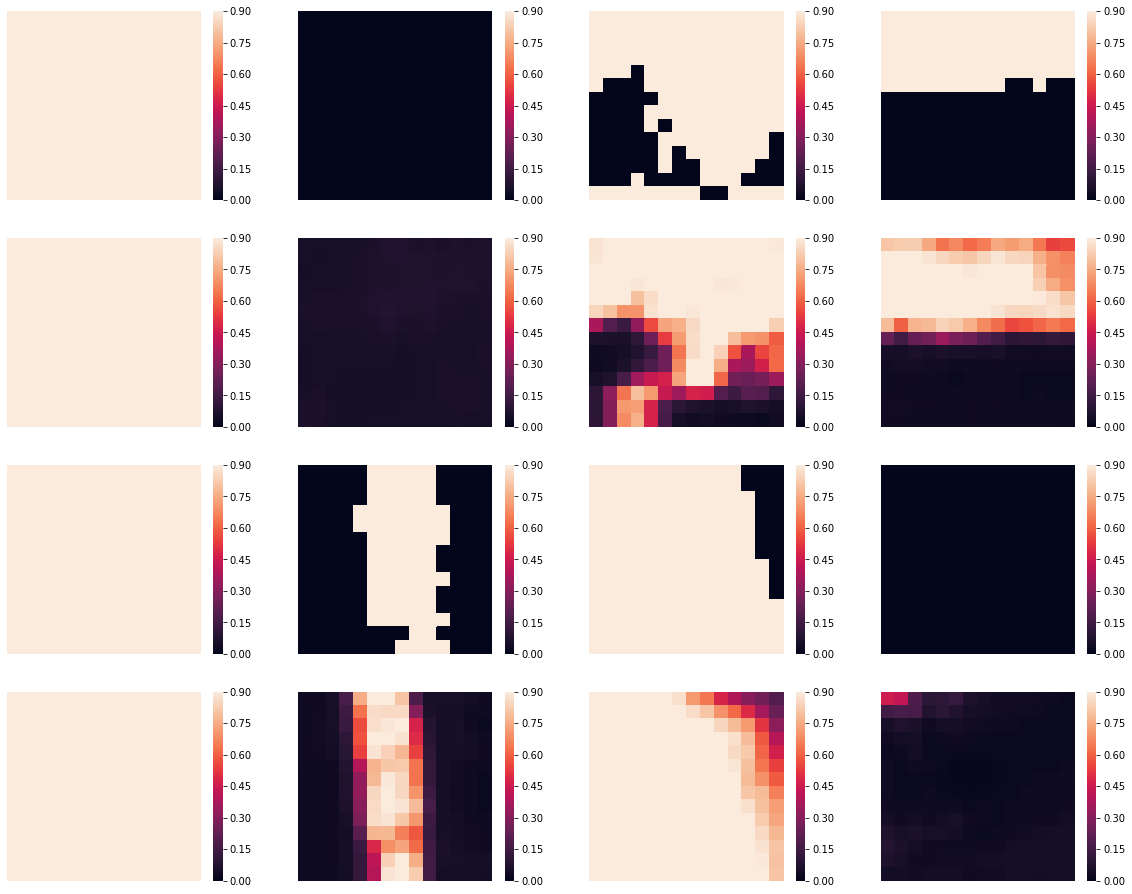

In [66]:
from sklearn.metrics import f1_score
print(start/len(test_ids))
test_ids = sorted(test_ids)
matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]
preds = []
trues = []
print(matrix_ids)
for i in matrix_ids:
    idx = i
    y = sess.run([fm], feed_dict={inp: test_x[idx].reshape(1, 24, 16, 16, 16),
                                  length: test_lengths[idx].reshape(1, 1),
                                  clipping_params['rmax']: 5,
                                  clipping_params['rmin']: 0,
                                  clipping_params['dmax']: 3,
                                  })
    y = np.array(y).reshape(14, 14)
    preds.append(y)
    y2 = np.copy(y)
    true = test_y[idx].reshape(14, 14)
    trues.append(true)
    
    
""


to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]

multiplot(to_plot, nrows = 4, ncols = 4)
start = start + 8 


In [12]:
preds, trues, diffs = run_predictions(test_x, test_y, test_lengths, debug = True)
best_f1, best_thresh = calc_f1(trues, preds)
print("F1 score: {}, thresh: {}".format(best_f1, best_thresh))


F1 score: 0.8353622811014908, thresh: 0.54


# Biome threshold selection

- Rainforest
- Hyperarid
- Temperate
- Arid
- Grassland

# Region threshold selection
- Latin america
- Global
- East africa
- West africa
- India

In [13]:
countries = {'ethiopia-test': [0, 112],
 'kenya-test': [113, 201],
 'ghana-test': [201, 235],
 'ghana-test-large': [235, 271],
 'africaeast-test': [271, 306],
 'india-test': [306, 357],
 'lac-north-test': [357, 398],
 'africawest-test': [398, 460],
 'cameroon-test': [460, 499],
 'lac-south-test': [499, 540],
 'global-test': [540, 682]}

In [14]:
# Ethiopia
f1_diffs = []
for i in countries.keys():
    start = countries[i][0]
    end = countries[i][1]
    preds, trues, _ = run_predictions(test_x[start:end], 
                               test_y[start:end],
                               test_lengths[start:end])
    
    best_f1, best_thresh = calc_f1(trues, preds)
    orig_f1, _ = calc_f1(trues, preds, threshold = 0.56)
    f1_diffs.append(best_f1 - orig_f1)
    print("{}: original F1: {}".format(i, orig_f1))
    print("{}: F1 score: {}, thresh: {}".format(i, best_f1, best_thresh))


ethiopia-test: original F1: 0.8256046834077955
ethiopia-test: F1 score: 0.8265834348355664, thresh: 0.54


KeyboardInterrupt: 

In [16]:
0.846 + np.mean(f1_diffs)

0.8497256112103161

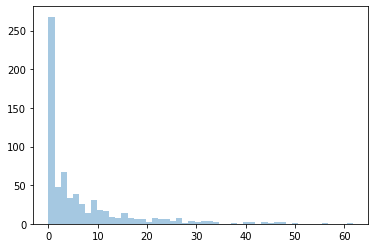

In [232]:
sns.distplot(np.array(diffs) / 1.96, bins = 50, kde = False)

In [229]:
np.percentile(np.array(diffs) / 1.96, 50)

2.5510204081632653

# Small pixel recovering

# To do: grid search over a range of thresholds and options to ID best solution

In [15]:
def recover_pixels(stacked, thresh, thresh_p):
    
    for window_x in range(2, stacked.shape[0]-2, 1):
        for window_y in range(2, stacked.shape[1]-2, 1):
            l, r, u, d =  False, False, False, False
            cur_window = stacked[window_x-2:window_x+3, window_y-2:window_y+3]
            hor_vert_neighbors = False
            if (cur_window[2, 2] > thresh and
                cur_window[2, 2] < thresh_p):
                if cur_window[3, 2] > thresh * 2 and cur_window[4, 2] < thresh * 2 :
                    hor_vert_neighbors = True
                    r = True
                if cur_window[1, 2] > thresh * 2 and cur_window[2, 0] < thresh * 2:
                    hor_vert_neighbors = True
                    l = True
                if cur_window[2, 3] > thresh * 2 and cur_window[2, 4] < thresh * 2:
                    hor_vert_neighbors = True
                    d = True
                if cur_window[2, 1] > thresh * 2 and cur_window[2, 0] < thresh * 2:
                    hor_vert_neighbors = True
                    u = True
            passes = False
            if r and not l:
                passes = True
            if l and not r:
                passes = True
            if d and not u:
                passes = True
            if u and not d:
                passes = True

            if passes:
                if r:
                    if cur_window[1, 1] < thresh * 2 and cur_window[1, 3] < thresh * 2:
                        #print("Adding a tree with: {}".format(cur_window[2, 2]))
                        stacked[window_x, window_y] = (thresh_p + 0.01)

                if l:
                    if cur_window[3, 1] < thresh * 2 and cur_window[3, 3] < thresh * 2:
                        #print("Adding a tree with: {}".format(cur_window[2, 2]))
                        stacked[window_x, window_y] = (thresh_p + 0.01)

                if u:
                    if cur_window[1, 3] < thresh * 2 and cur_window[3, 3] < thresh * 2:
                        #print("Adding a tree with: {}".format(cur_window[2, 2]))
                        stacked[window_x, window_y] = (thresh_p + 0.01)

                if d:
                    if cur_window[1, 1] < thresh * 2 and cur_window[3, 1] < thresh * 2:
                        #print("Adding a tree with: {}".format(cur_window[2, 2]))
                        stacked[window_x, window_y] = (thresh_p + 0.01)
                        
    return stacked

In [181]:
start = 523

0.8058823529411765
[548, 549, 550, 551, 552, 553, 554, 555]
548 0.0
549 0.0
550 0.0
551 0.0
552 3.0
553 8.0
554 0.0
555 16.0


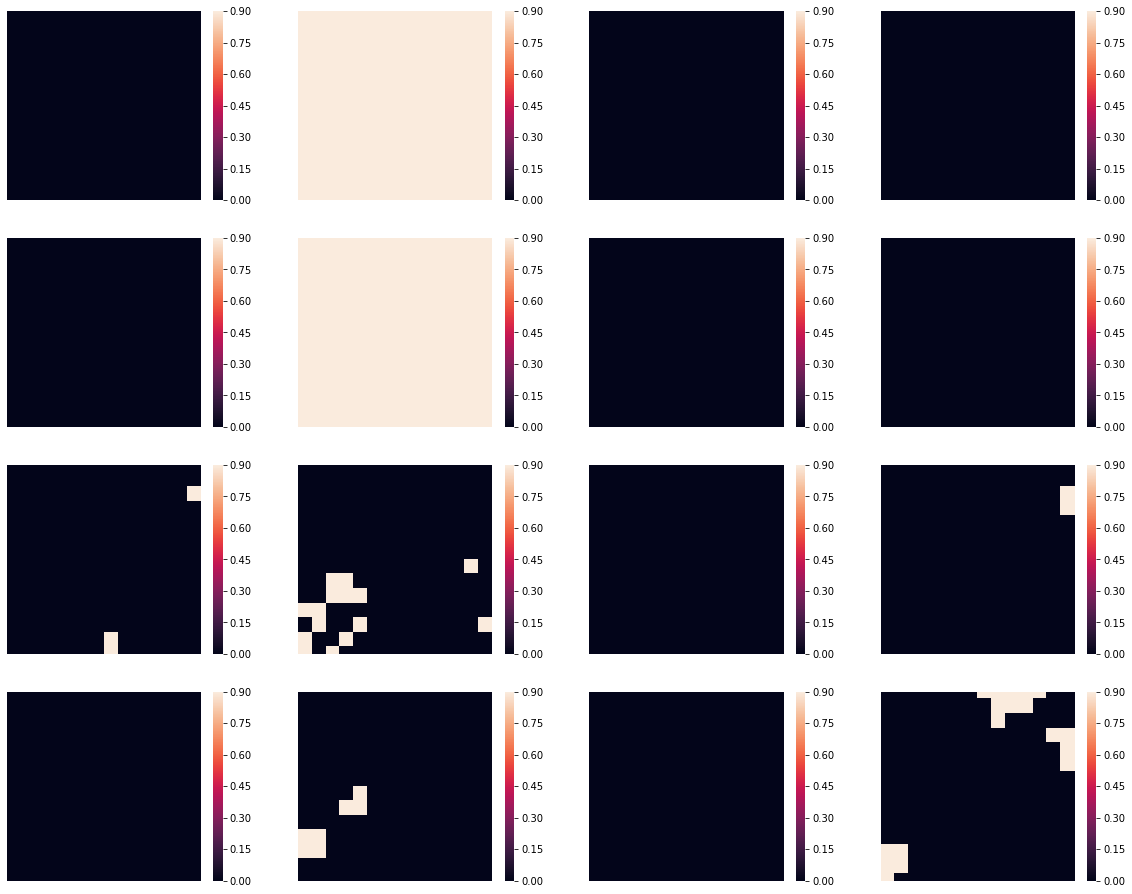

In [214]:
from sklearn.metrics import f1_score
print(start/len(test_ids))
test_ids = sorted(test_ids)
matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]
preds = []
trues = []
print(matrix_ids)
for i in matrix_ids:
    idx = i
    y = sess.run([fm], feed_dict={inp: test_x[idx].reshape(1, 24, 16, 16, 16),
                                  length: test_lengths[idx].reshape(1, 1),
                                  clipping_params['rmax']: 5,
                                  clipping_params['rmin']: 0,
                                  clipping_params['dmax']: 3,
                                  })
    y = np.array(y).reshape(14, 14)
    y2 = np.copy(y)
    y[np.where(y >= 0.5)] = 1.
    y[np.where(y < 0.5)] = 0.
    
    initial_f1 = f1_score(test_y[idx].flatten(), y.flatten())
    y2 = recover_pixels(y2, 0.4, 0.58)
    y2[np.where(y2 >= 0.5)] = 1.
    y2[np.where(y2 < 0.5)] = 0.
    after_f1 = f1_score(test_y[idx].flatten(), y2.flatten())
    #print(after_f1 - initial_f1)
    print(idx, abs(np.sum(y) - np.sum(test_y[idx])))
    
    preds.append(y)
    y2 = np.copy(y)
    true = test_y[idx].reshape(14, 14)
    trues.append(true)
    
    
""


to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]

multiplot(to_plot, nrows = 4, ncols = 4)
start = start + 8 



# Smooth windowed predictions

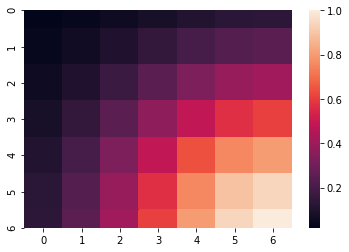

In [334]:
def fspecial_gauss(size, sigma):

    """Function to mimic the 'fspecial' gaussian MATLAB function
    """

    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g

arr = fspecial_gauss(14, 3)
arr = arr[:7, :7]
sns.heatmap(arr)

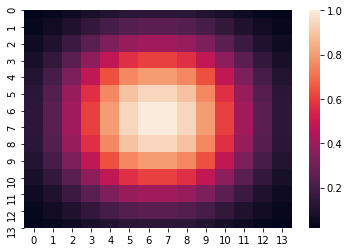

In [335]:
base_filter = np.concatenate([arr, np.flip(arr, 0)], 0)
base_filter = np.concatenate([base_filter, np.flip(base_filter, 1)], 1) 
sns.heatmap(base_filter)

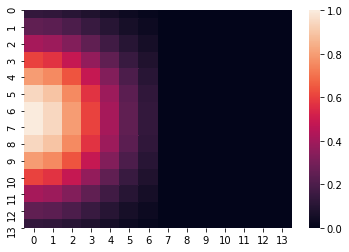

In [336]:
right_filter = base_filter[:, 7:]
right_filter = np.pad(right_filter, ((0, 0), (0, 7)), mode = 'constant', constant_values = 0)
sns.heatmap(right_filter)

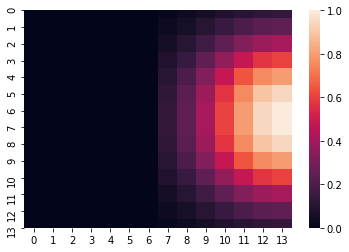

In [337]:
left_filter = base_filter[:, :7]
left_filter = np.pad(left_filter, ((0, 0), (7, 0)), mode = 'constant', constant_values = 0)
sns.heatmap(left_filter)

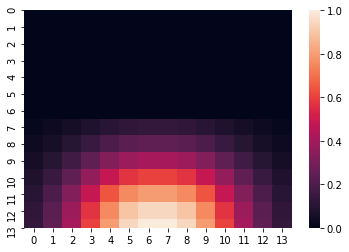

In [338]:
up_filter = base_filter[:7, :]
up_filter = np.pad(up_filter, ((7, 0), (0, 0)), mode = 'constant', constant_values = 0)
sns.heatmap(up_filter)

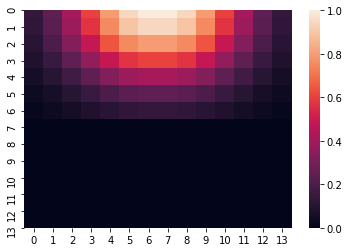

In [339]:
down_filter = base_filter[7:, :]
down_filter = np.pad(down_filter, ((0, 7), (0, 0)), mode = 'constant', constant_values = 0)
sns.heatmap(down_filter)

In [340]:
sums =  base_filter + down_filter + up_filter + left_filter + right_filter 
left_filter /= sums
right_filter /= sums
base_filter /= sums
down_filter /= sums
up_filter /= sums

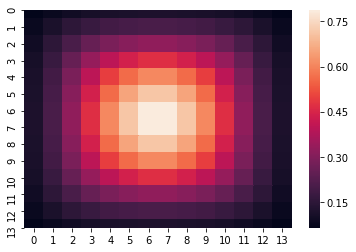

In [341]:
sns.heatmap(base_filter)

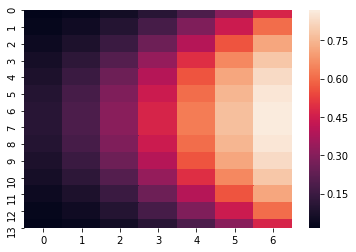

In [342]:
sns.heatmap(left_filter[:, 7:])

In [351]:
from skimage.transform import resize


test_x = np.load("../tile_data/processed/test_x_tile.npy")
test_y = np.load("../tile_data/processed/test_y_tile.npy")
test_lengths = np.array([24] * len(test_x))

test_x = np.delete(test_x, 14, -1)

outliers = [594, 547, 572]
        
test_x = test_x[[x for x in range(0, len(test_x)) if x not in outliers]]
test_y = test_y[[x for x in range(0, len(test_y)) if x not in outliers]]
test_lengths = test_lengths[[x for x in range(0, len(test_lengths)) if x not in outliers]]

for sample in tnrange(0, len(test_x)):
    filtered = median_filter(test_x[sample, 0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (16, 2, 16, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (32, 32), 0)
    test_x[sample, :, :, :, 10] = np.stack([filtered] * 24)
    
for band in range(0, test_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    test_x[:, :, :, :, band] = np.clip(test_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (test_x[:, :, :, :, band] - midrange) / (rng / 2)
    test_x[:, :, :, :, band] = standardized
    
    
print("The data has been scaled to [{}, {}]".format(np.min(test_x), np.max(test_x)))
print(test_x.shape)


The data has been scaled to [-1.0000001192092896, 1.0000001192092896]
(679, 24, 32, 32, 16)


In [344]:
test_x = test_x[:, :, 8:-8, 8:-8, :]

In [345]:
preds, trues, diffs = run_predictions(test_x, test_y, test_lengths, debug = False)
best_f1, best_thresh = calc_f1(trues, preds)
print("F1 score: {}, thresh: {}".format(best_f1, best_thresh))


F1 score: 0.8200094633405592, thresh: 0.56


In [346]:
tile_lookups = { #'x_start, y_start'
    'center': [8, 8],
    'down': [1, 8],
    'up': [15, 8],
    'right': [8, 15],
    'left': [8, 1],
    'ul': [16, 0],
    'ur': [16, 16],
    'dl': [0, 0],
    'dr': [0, 16],
}

def make_5d_array(arr, tile_lookups):
    arr_5d = np.empty((9, 24, 16, 16, 16))
    print(arr.shape)
    for i in range(len(tile_lookups.keys())):
        key = list(tile_lookups.keys())[i]
        start_x = tile_lookups[key][0]
        start_y = tile_lookups[key][1]
        arr_5d[i] = arr[:24, start_x:start_x+16, start_y:start_y+16, :]
    return arr_5d

def reconstruct_array(arr):
    
    out = np.copy(arr[0])
    
    center = arr[0] * base_filter
    down = arr[1][7:, :]
    down = np.pad(down, ((0, 7), (0, 0)), mode = 'constant', constant_values = 0)
    down *= down_filter
    
    up = arr[2][:7, :]
    up = np.pad(up, ((7, 0), (0, 0)), mode = 'constant', constant_values = 0)
    up *= up_filter
    
    left = arr[4][:, 7:]
    left = np.pad(left, ((0, 0), (0, 7)), mode = 'constant', constant_values = 0)
    left *= right_filter
    
    right = arr[3][:, :7]
    right = np.pad(right, ((0, 0), (7, 0)), mode = 'constant', constant_values = 0)
    right *= left_filter
    
    
    
    #down = (arr[1] * up_filter)[7:, :]
    #up = (arr[2] * down_filter)[:7, :]
    #right = (arr[3] * right_filter)[:, :7]
    #left = (arr[4] * left_filter)[:, 7:]

    #out[:, 7:] = center[:, 7:] + right
    #out[:, :7] = center[:, :7] + left
    #out[:7, :] = center[:7, :] + down
    #out[7:, :] = center[7:, :] + up

    return (center + down + up + right + left)
    
    
    
    
    

In [347]:
idx = 65

def run_5d_array(idx):
    five_d = make_5d_array(test_x[idx], tile_lookups)

    y = sess.run([fm], feed_dict={inp: five_d[0].reshape(1, 24, 16, 16, 16),
                                  length: test_lengths[0].reshape(1, 1),
                                  clipping_params['rmax']: 5,
                                  clipping_params['rmin']: 0,
                                  clipping_params['dmax']: 3,
                                  })
    ys = []
    for i in range(0, 9):
        y = sess.run([fm], feed_dict={inp: five_d[i].reshape(1, 24, 16, 16, 16),
                                      length: test_lengths[0].reshape(1, 1),
                                      clipping_params['rmax']: 5,
                                      clipping_params['rmin']: 0,
                                      clipping_params['dmax']: 3,
                                      })
        ys.append(np.array(y).reshape((14, 14)))
    ys = np.stack(ys)
    pr = reconstruct_array(ys)
    return pr




In [348]:
preds = run_5d_array(14)




(24, 16, 16, 16)


ValueError: could not broadcast input array from shape (24,8,8,16) into shape (24,16,16,16)

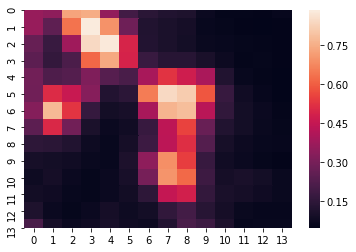

In [309]:
sns.heatmap(orig)

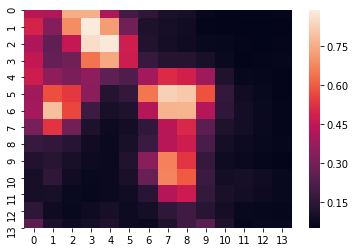

In [310]:
sns.heatmap(preds)

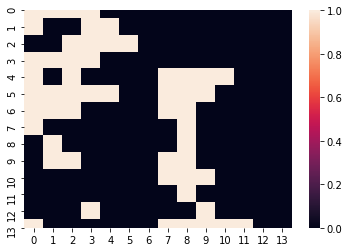

In [267]:
sns.heatmap(true)



In [311]:
windowed = [run_5d_array(x) for x in range(0, len(test_x))]




(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 1

(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 16)
(24, 32, 32, 1

In [276]:
# Sigma = 3.5
preds = np.stack(windowed).flatten()
best_f1, best_thresh = calc_f1(np.stack(test_y).flatten(), preds)
print("F1 score: {}, thresh: {}".format(best_f1, best_thresh))

F1 score: 0.8196981051279306, thresh: 0.56


In [312]:
# Sigma = 2.0
preds = np.stack(windowed).flatten()
best_f1, best_thresh = calc_f1(np.stack(test_y).flatten(), preds)
print("F1 score: {}, thresh: {}".format(best_f1, best_thresh))

F1 score: 0.8203989227583395, thresh: 0.56


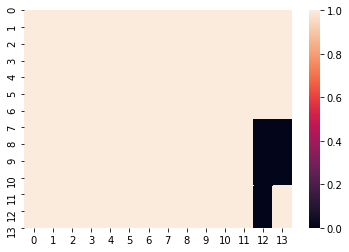

In [313]:
sns.heatmap(test_y[idx].reshape((14, 14)))